https://github.com/nikolausrauch/geometric-multigrid/blob/main/multigrid.ipynb

In [8]:
import numpy as np
import matplotlib.pyplot as plt


In [9]:
def Jacobi(A, x, b, iter=3, omega=2/3):
    L, D, U = np.triu(A, k=1), np.diag(np.diag(A, k=0)), np.tril(A, k=-1)
    D_inv = np.diag(1.0 / np.diag(D))

    r = b - A @ x
    res = np.inner(r, r)

    for i in range(1, iter):
        r = b - A @ x
        x = x + omega * D_inv @ r
        res = np.inner(r, r)

    return x

In [10]:
def restrict_mat(size, dim):
    size = int(size) if dim == 1 else int(np.sqrt(size))

    R = np.zeros((int(size/2), size))
    R.flat[0:R.size:size+2] = (1.0/4.0) * 1
    R.flat[1:R.size:size+2] = (1.0/4.0) * 2
    R.flat[2:R.size:size+2] = (1.0/4.0) * 1

    if dim == 2:
        R = np.kron(R, R)
    # print(R)
    # print("hi")
    return R

In [11]:
def prolongate_mat(size, dim):
    R = restrict_mat(size, dim)

    return (2.0 * R.T) if dim == 1 else (4.0 * R.T)

In [12]:
def mu_cycle(A, v, f, mu, depth, dim):

    if depth == 0 or len(v) == 1:
        u = np.linalg.inv(A) @ f
        return u

    u = Jacobi(A, v, f)
    r = f - A @ u
    
    R = restrict_mat(len(v), dim)
    I = prolongate_mat(len(v), dim)

    A_2h = R @ A @ I
    r_2h = R @ r
    e_2h = np.zeros(len(r_2h))
    for _ in range(0, 1):
        e_2h = mu_cycle(A_2h, e_2h, r_2h, mu, depth - 1, dim)

    u += I @ e_2h
    u = Jacobi(A, u, f)

    return u

def Multigrid(A, x, b, mu, iterations, depth=1):
    r = b - A @ x
    res = np.inner(r, r)

    while res > 1e-8 and iterations > 0:
        x = mu_cycle(A, x, b, mu, depth, dim=2)
        r = b - A @ x
        res = np.inner(r, r)
        iterations -= 1
    
    return x

In [13]:
sigma = 0
lower = 0.0
upper = 1.0

L = upper - lower
N = 2*10 + 1
h = L/N
n = N - 2
fourier_modes = lambda i, j, k, n: np.sin( i*k*np.pi / n ) * np.sin( j*k*np.pi / n )

# Discretization Matrix
A = np.kron(np.diag(np.ones(n - 1), -1) + np.diag(np.ones(n - 1), 1), -np.eye(n))
D = -1.0 * np.diag(np.ones(n-1), -1) + -1.0 * np.diag(np.ones(n-1), 1) + 4 * np.diag(np.ones(n), 0)
A += np.kron(np.diag(np.ones(n), 0), D)

numX, numY = np.meshgrid(np.arange(N), np.arange(N))

# initial guess
v = (1.0 / 3.0) * (fourier_modes(numX, numY, 1, N-1) + fourier_modes(numX, numY, 6, N-1) + fourier_modes(numX, numY, 32, N-1))

# rh side
f = np.random.rand( n**2 ) # * h**2 #np.zeros(n**2)

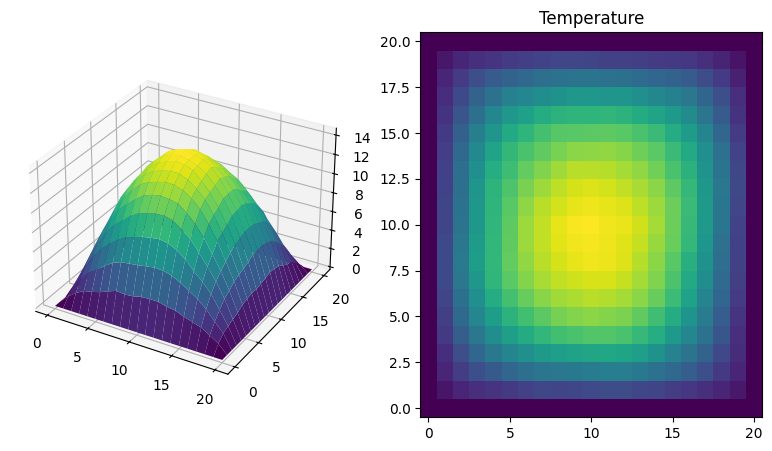

In [14]:
_v = v.copy()
u = _v[1:-1, 1:-1].flatten().copy()
u = Multigrid(A, u, f, 1, 1, depth=1)
_v[1:-1, 1:-1] = u.reshape(n, n)

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.plot_surface(numX, numY, _v, cmap='viridis', edgecolor='none')

ax = fig.add_subplot(1, 3, 2)
ax.set_title("Temperature")
ax.pcolormesh(numX, numY, _v, cmap='viridis', shading='auto')
